## Image segmentation with CamVid

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *

In [4]:
path = untar_data(URLs.CAMVID)
path.ls()

[PosixPath('/gpfs/home/s4s004/racheseb/.fastai/data/camvid/labels'),
 PosixPath('/gpfs/home/s4s004/racheseb/.fastai/data/camvid/images'),
 PosixPath('/gpfs/home/s4s004/racheseb/.fastai/data/camvid/codes.txt'),
 PosixPath('/gpfs/home/s4s004/racheseb/.fastai/data/camvid/valid.txt')]

In [5]:
path_lbl = path/'labels'
path_img = path/'images'

## Subset classes

In [6]:
# path = Path('./data/camvid-small')

# def get_y_fn(x): return Path(str(x.parent)+'annot')/x.name

# codes = array(['Sky', 'Building', 'Pole', 'Road', 'Sidewalk', 'Tree',
#     'Sign', 'Fence', 'Car', 'Pedestrian', 'Cyclist', 'Void'])

# src = (SegmentationItemList.from_folder(path)
#        .split_by_folder(valid='val')
#        .label_from_func(get_y_fn, classes=codes))

# bs=8
# data = (src.transform(get_transforms(), tfm_y=True)
#         .databunch(bs=bs)
#         .normalize(imagenet_stats))

## Data

In [7]:
fnames = get_image_files(path_img)
fnames[:3]

[PosixPath('/gpfs/home/s4s004/racheseb/.fastai/data/camvid/images/0016E5_08091.png'),
 PosixPath('/gpfs/home/s4s004/racheseb/.fastai/data/camvid/images/Seq05VD_f04740.png'),
 PosixPath('/gpfs/home/s4s004/racheseb/.fastai/data/camvid/images/0001TP_007200.png')]

In [8]:
lbl_names = get_image_files(path_lbl)
lbl_names[:3]

[PosixPath('/gpfs/home/s4s004/racheseb/.fastai/data/camvid/labels/0001TP_010320_P.png'),
 PosixPath('/gpfs/home/s4s004/racheseb/.fastai/data/camvid/labels/Seq05VD_f02970_P.png'),
 PosixPath('/gpfs/home/s4s004/racheseb/.fastai/data/camvid/labels/0016E5_05010_P.png')]

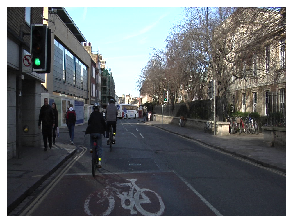

In [9]:
img_f = fnames[0]
#img_f = fnames[653]
img = open_image(img_f)
img.show(figsize=(5,5))

In [10]:
# Function - pass in an image name, return a different image name that appends _P to end of the file
get_y_fn = lambda x: path_lbl/f'{x.stem}_P{x.suffix}'

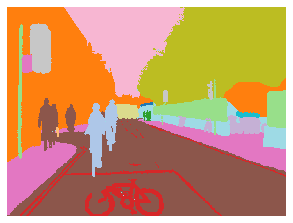

In [11]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)

In [12]:
src_size = np.array(mask.shape[1:])
src_size,mask.data

(array([720, 960]),
 tensor([[[ 4,  4,  4,  ..., 26, 26, 26],
          [ 4,  4,  4,  ..., 26, 26, 26],
          [ 4,  4,  4,  ..., 26, 26, 26],
          ...,
          [19, 19, 19,  ..., 17, 17, 17],
          [17, 17, 19,  ..., 17, 17, 17],
          [17, 17, 17,  ..., 17, 17, 17]]]))

In [13]:
codes = np.loadtxt(path/'codes.txt', dtype=str); codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole',
       'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock',
       'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

## Datasets

In [14]:
size = src_size//2

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=8
else:           bs=4
print(f"using bs={bs}, have {free}MB of GPU RAM free")

using bs=4, have 3825MB of GPU RAM free


In [15]:
src = (SegmentationItemList.from_folder(path_img)
       .split_by_fname_file('../valid.txt')
       .label_from_func(get_y_fn, classes=codes))

In [16]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

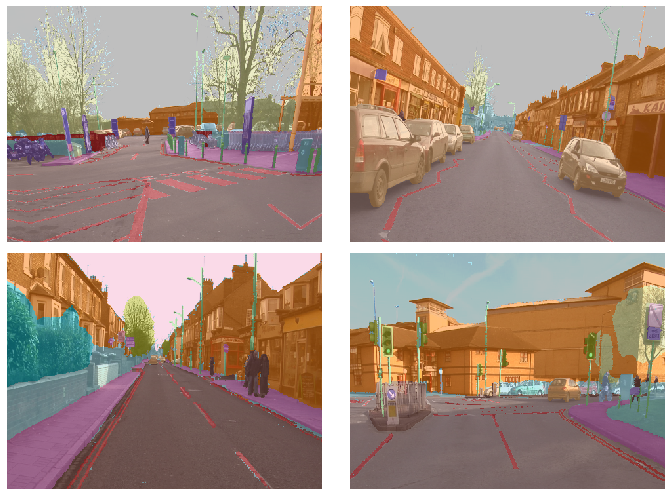

In [17]:
data.show_batch(2, figsize=(10,7))

In [18]:
??data.show_batch

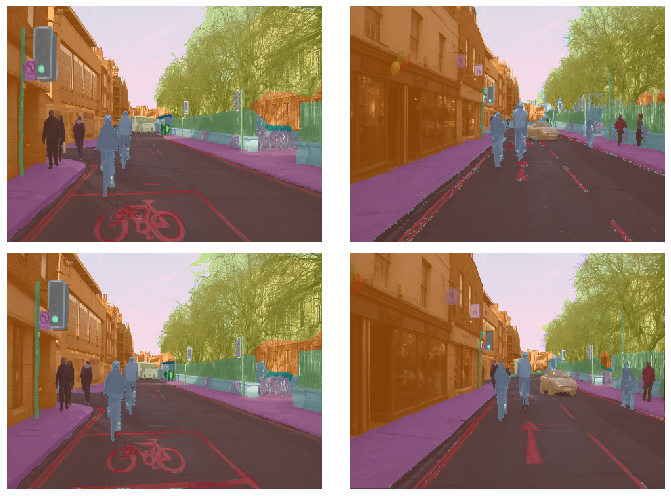

In [19]:
data.show_batch(2, figsize=(10,7), ds_type=DatasetType.Valid)

## Model

In [20]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

def acc_camvid(input, target):
    target = target.squeeze(1)  # The squeeze() function eliminate any dimension that has size 1. 
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [21]:
metrics=acc_camvid
# metrics=accuracy

In [22]:
wd=1e-2

In [67]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd).to_fp16()

epoch,train_loss,valid_loss,acc_camvid,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


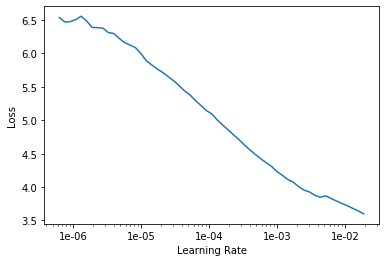

In [69]:
# takes less than a minute
lr_find(learn)
learn.recorder.plot()

In [25]:
lr=3e-3

### Skip this time limiting step for  Demo

##### learn.fit_one_cycle(10, slice(lr), pct_start=0.9)

The following step takes on the order of 10 minutes to complete


To actually run the following cell - uncomment it and run the learn and also run the save command

![ex3_Segmentation_Camvid_5.1.0.1%20%20learn.fit_one_cycle%2810,%20slice(lr%29,%20pct_start=0.9).png](attachment:ex3_Segmentation_Camvid_5.1.0.1%20%20learn.fit_one_cycle%2810,%20slice(lr%29,%20pct_start=0.9).png)
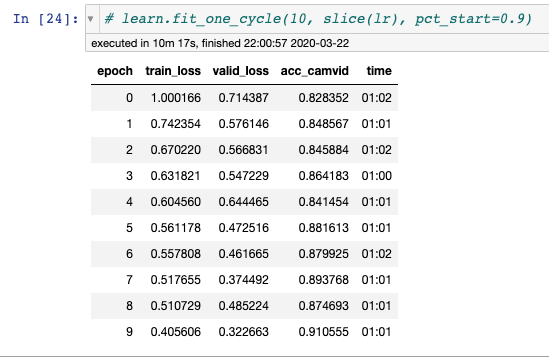

In [27]:
 #learn.fit_one_cycle(10, slice(lr), pct_start=0.9)

In [ ]:
# learn.save('stage-1')

In [28]:
learn.load('stage-1');

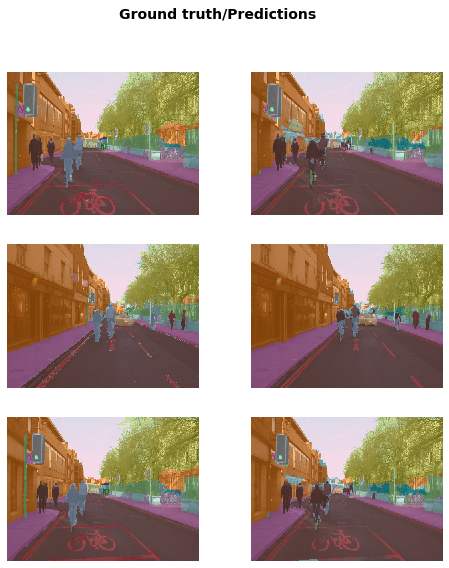

In [29]:
learn.show_results(rows=3, figsize=(8,9))

In [34]:
learn.summary

<bound method model_summary of Learner(data=ImageDataBunch;

Train: LabelList (600 items)
x: SegmentationItemList
Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480)
y: SegmentationLabelList
ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480)
Path: /gpfs/home/s4s004/racheseb/.fastai/data/camvid/images;

Valid: LabelList (101 items)
x: SegmentationItemList
Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480)
y: SegmentationLabelList
ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480)
Path: /gpfs/home/s4s004/racheseb/.fastai/data/camvid/images;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64

In [35]:
learn.unfreeze()

In [36]:
lrs = slice(lr/400,lr/4)

### learn.fit_one_cycle(12, lrs, pct_start=0.8)   Executes in 12 minutes

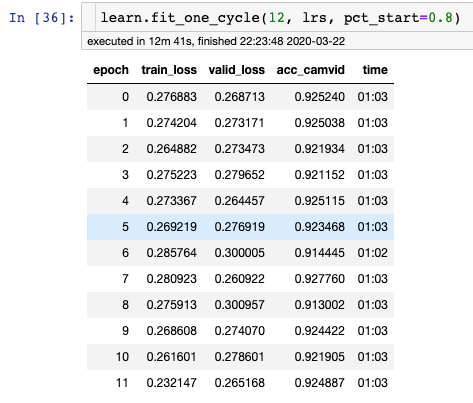

In [37]:
learn.fit_one_cycle(12, lrs, pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.282518,0.268847,0.926369,01:04
1,0.280930,0.277376,0.922054,01:03
2,0.272652,0.263310,0.926983,01:03
3,0.269499,0.275002,0.922554,01:03
4,0.268457,0.279620,0.920659,01:03
5,0.274698,0.301006,0.917493,01:03
6,0.268799,0.268227,0.928465,01:03
7,0.272564,0.266647,0.926963,01:03
8,0.285037,0.271327,0.926792,01:03
9,0.280899,0.266642,0.928565,01:03


In [38]:
learn.save('stage-2');

## Go big

You may have to restart your kernel and come back to this stage if you run out of memory, and may also need to decrease `bs`.

In [81]:
#learn.destroy()

size = src_size

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=3
else:           bs=1
print(f"using bs={bs}, have {free}MB of GPU RAM free")

using bs=1, have 3825MB of GPU RAM free


In [86]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [87]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

In [88]:
learn.load('stage-2');

epoch,train_loss,valid_loss,acc_camvid,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


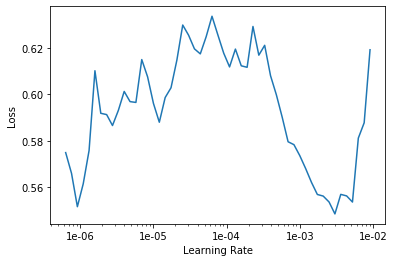

In [89]:
lr_find(learn)
learn.recorder.plot()

In [90]:
lr=1e-3

#### The learn.fit_one_cycle(10, slice(lr), pct_start=0.8) takes 32 minutes to complete

skip it and load the result if pressed for time



![ex3_Segmentation_Camvid_6.0.1learn.fit_one_cycle%2810,%20slice(lr%29,%20pct_start=0.8).png](attachment:ex3_Segmentation_Camvid_6.0.1learn.fit_one_cycle%2810,%20slice(lr%29,%20pct_start=0.8).png)
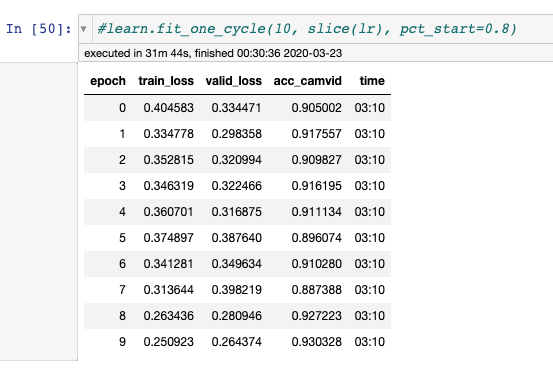

In [91]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.416254,0.324231,0.914227,03:11
1,0.400596,0.313934,0.915332,03:11
2,0.351339,0.329629,0.913352,03:11
3,0.324357,0.367162,0.912349,03:11
4,0.368738,0.338801,0.911265,03:11
5,0.351405,0.294824,0.918500,03:12
6,0.345635,0.331434,0.913071,03:11
7,0.312621,0.322896,0.913857,03:11
8,0.319481,0.280039,0.925425,03:11
9,0.249208,0.268426,0.929130,03:11


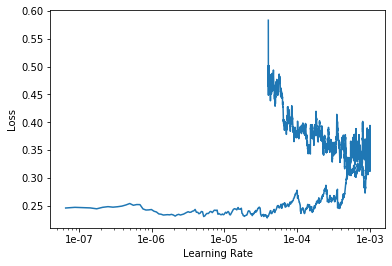

In [92]:
learn.recorder.plot()

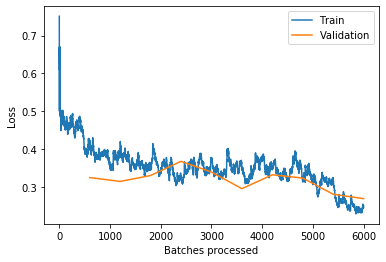

In [93]:
learn.recorder.plot_losses()

In [61]:
learn.save('stage-1-big')

In [62]:
learn.load('stage-1-big');

In [63]:
learn.unfreeze()

In [49]:
lrs = slice(1e-6,lr/10)

#### learn.fit_one_cycle(10, lrs) Takes 33 min

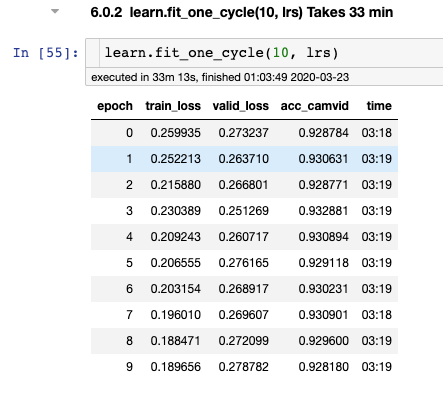

In [66]:
learn.fit_one_cycle(10, lrs).to_fp16()

epoch,train_loss,valid_loss,acc_camvid,time
0,0.177675,0.269361,0.934075,03:20
1,0.170094,0.264197,0.934559,03:20


KeyboardInterrupt: 

In [52]:
#learn.save('stage-2-big')

In [53]:
learn.load('stage-2-big');

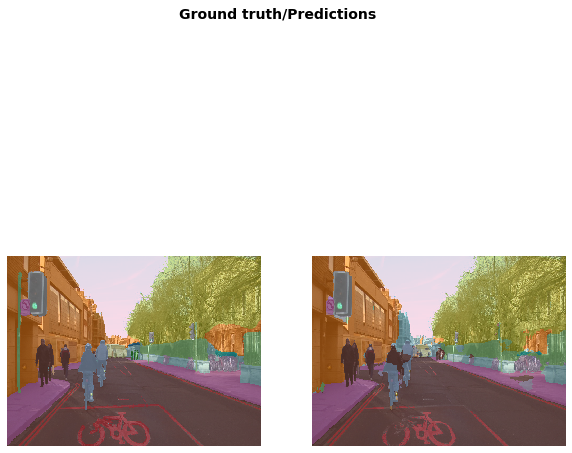

In [54]:
learn.show_results(rows=3, figsize=(10,10))

## fin